<a href="https://colab.research.google.com/github/mingyun642/sewon-This-code_8-29/blob/main/GAN_%EA%B5%AC%ED%98%84_8_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.optimizers import Adam
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'# not to show warning

# 하이퍼파라미터
n_learn = 20001
interval = 1000
batch_size = 32
n_noize = 128
img_size = 28
alpha = 0.2

# 학습률 설정
optimizer_d = Adam(0.0002, 0.5)
optimizer_g = Adam(0.0001, 0.5)

# 데이터 로드
(x_train, t_train), (_, _) = mnist.load_data()
x_train = x_train / 255.0 * 2 - 1  # [-1, 1] 범위로 정규화
x_train = x_train.reshape(x_train.shape[0], -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
# Generator
generator = Sequential([
    Dense(128, input_shape=(n_noize,)),
    LeakyReLU(alpha=alpha),
    Dense(256),
    LeakyReLU(alpha=alpha),
    Dense(img_size**2, activation="tanh")
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [3]:

# Discriminator
discriminator = Sequential([
    Dense(512, input_shape=(img_size**2,)),
    LeakyReLU(alpha=alpha),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(alpha=alpha),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer_d, metrics=["accuracy"])


In [4]:

# GAN 구성
discriminator.trainable = False
noise = Input(shape=(n_noize,))
gen_img = generator(noise)
validity = discriminator(gen_img)
combined = Model(noise, validity)
combined.compile(loss="binary_crossentropy", optimizer=optimizer_g)

In [5]:
# 이미지 생성 함수
def generate_images(i):
    n_samples = 16
    n_noise=128
    noise = np.random.normal(0, 1, (n_samples, n_noise))
    g_imgs = generator.predict(noise, verbose=0)

    # 이미지 시각화
    matrix_image = np.zeros((img_size * 4, img_size * 4))
    for r in range(4):
        for c in range(4):
            g_img = g_imgs[r * 4 + c].reshape(img_size, img_size)
            matrix_image[r*img_size:(r+1)*img_size, c*img_size:(c+1)*img_size] = g_img

    plt.figure(figsize=(4, 4))
    plt.imshow(matrix_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Step {i}")
    plt.show()


n_learn: 0
loss_fake: 0.9453, acc_fake: 0.2812
loss_real: 1.2172, acc_real: 0.0000
loss_comb: 0.8131


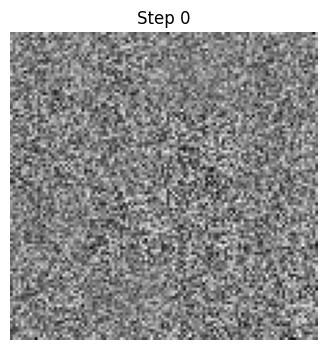

n_learn: 1000
loss_fake: 0.4022, acc_fake: 0.4387
loss_real: 0.4022, acc_real: 0.4385
loss_comb: 2.0605


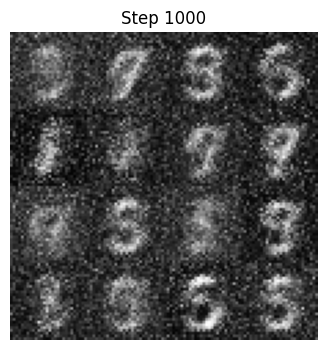

n_learn: 2000
loss_fake: 0.4055, acc_fake: 0.4445
loss_real: 0.4055, acc_real: 0.4444
loss_comb: 2.1542


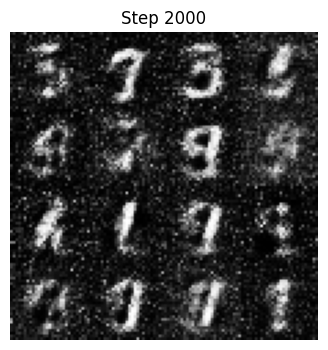

n_learn: 3000
loss_fake: 0.4117, acc_fake: 0.4461
loss_real: 0.4118, acc_real: 0.4460
loss_comb: 2.1611


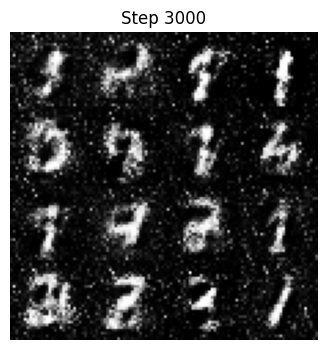

n_learn: 4000
loss_fake: 0.4193, acc_fake: 0.4452
loss_real: 0.4194, acc_real: 0.4451
loss_comb: 2.1414


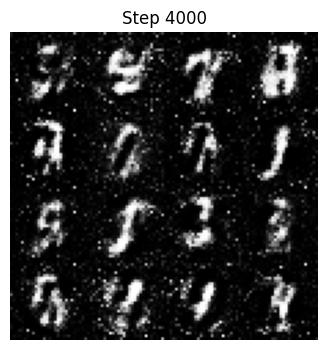

n_learn: 5000
loss_fake: 0.4270, acc_fake: 0.4436
loss_real: 0.4270, acc_real: 0.4435
loss_comb: 2.1094


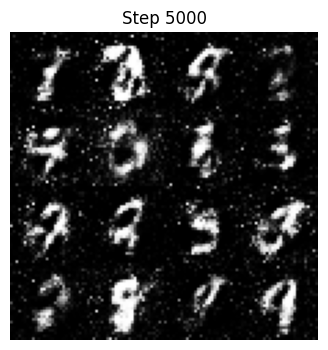

n_learn: 6000
loss_fake: 0.4307, acc_fake: 0.4431
loss_real: 0.4308, acc_real: 0.4431
loss_comb: 2.0968


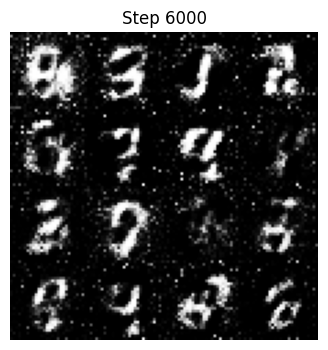

In [ ]:
# 학습 루프
batch_half = batch_size // 2
loss_record = np.zeros((n_learn, 3))
acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):
    # -------------------------
    #  Train Discriminator
    # -------------------------
    g_noise = np.random.normal(0, 1, (batch_half, n_noize))
    g_imgs = generator(g_noise, training=False).numpy()

    real_idxs = np.random.randint(0, x_train.shape[0], batch_half)
    real_imgs = x_train[real_idxs]

    # Label smoothing (real: 0.9), label flipping (fake: 0.1 with p=0.05)
    real_labels = np.ones((batch_half, 1)) * 0.9
    flip_prob = 0.05
    fake_labels = np.random.choice([0.0, 0.1], size=(batch_half, 1), p=[1 - flip_prob, flip_prob])

    discriminator.trainable = True
    loss_real, acc_real = discriminator.train_on_batch(real_imgs, real_labels)
    loss_fake, acc_fake = discriminator.train_on_batch(g_imgs, fake_labels)

    # -------------------------
    #  Train Generator
    # -------------------------
    c_noise = np.random.normal(0, 1, (batch_size, n_noize))
    discriminator.trainable = False
    loss_comb = combined.train_on_batch(c_noise, np.ones((batch_size, 1)))

    # 기록 저장
    loss_record[i] = [loss_fake, loss_real, loss_comb if not isinstance(loss_comb, list) else loss_comb[0]]
    acc_record[i] = [acc_fake, acc_real]

    # 출력
    if i % interval == 0:
        print(f"n_learn: {i}")
        print(f"loss_fake: {loss_fake:.4f}, acc_fake: {acc_fake:.4f}")
        print(f"loss_real: {loss_real:.4f}, acc_real: {acc_real:.4f}")
        print(f"loss_comb: {loss_comb:.4f}")
        generate_images(i)

In [ ]:
# 오차의 추이
n_plt_loss = 1000  # 오차의 표시 범위
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 0], label="loss_fake")
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 1], label="loss_real")
plt.plot(np.arange(n_plt_loss), loss_record[:n_plt_loss, 2], label="loss_comb")
plt.legend()
plt.title("Loss")
plt.show()

# 정밀도의 추이
n_plt_acc = 1000  # 정밀도의 표시 범위
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 0], label="acc_fake")
plt.plot(np.arange(n_plt_acc), acc_record[:n_plt_acc, 1], label="acc_real")
plt.legend()
plt.title("Accuracy")
plt.show()